In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

from glob import glob
import os
import shutil

import numpy as np
import pandas as pd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# AIM
## To classify the images into 
### IDC+
### IDC-

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
sampling_seed = 0
size_4_training0 = 6000
size_4_training1 = 6000
img_size = 224
training_reshape=(-1, img_size, img_size, 3)
epoch_4_test = 50

In [4]:
import os
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/') 

In [5]:

import random
from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    elif filename.endswith("class1.png"):
         class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [6]:
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training0)
class0label=np.zeros(size_4_training0)
class1sample=random.sample(class1,size_4_training1)
class1label=np.ones(size_4_training1)

class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_val, class0sample_test,  class0label_val, class0label_test = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_val, class1sample_test, class1label_val, class1label_test = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))

def read_and_save_data(path, file_name_array):
    for i in file_name_array:
        if i.endswith('.png'):
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            shutil.copy(i, outputname)
    
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)

4200
540
1260
4200
540
1260


In [7]:
import os #Operating System
import sys #System
import cv2
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)

def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1), axis=0)
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    # print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label,num_classes=2)
    
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)

In [8]:
print(len(class0_train))
print(len(class1_train))
print(len(class0_test))
print(len(class1_test))
print(len(class0_val))
print(len(class1_val))

4200
4200
540
540
1260
1260


# Model configure

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model =  VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=2,
    classifier_activation="sigmoid")
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)             

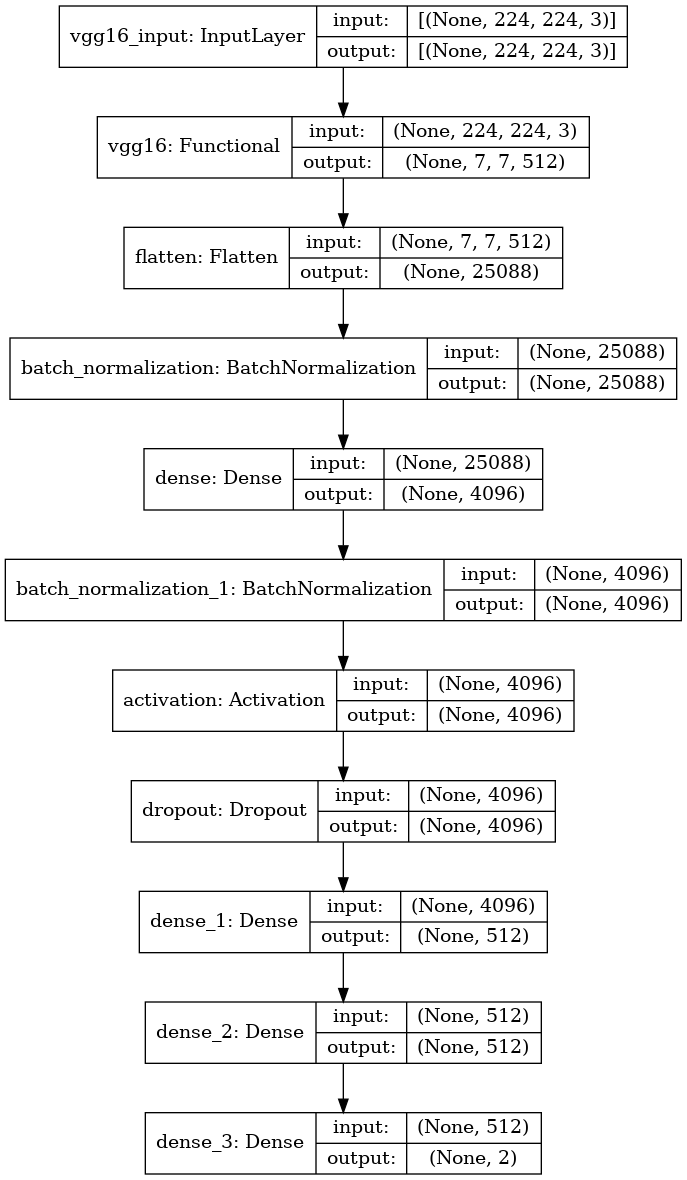

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png') 

In [11]:
# os.makedirs('../working/log/')
MODEL_INIT = '../working/init_model.h5'
MODEL_PATH = '../working/test_model.h5'

In [17]:
callbacks1 = [EarlyStopping(monitor='val_accuracy', patience=8, verbose=1), ModelCheckpoint(MODEL_INIT, monitor='val_accuracy', save_best_only=True)]
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
%time
history1=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 100, callbacks=callbacks1)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


2022-05-29 16:23:39.829158: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1264435200 exceeds 10% of free system memory.


Epoch 1/100
263/263 [==============================] - 22s 80ms/step - loss: 0.4761 - accuracy: 0.7935 - val_loss: 0.4138 - val_accuracy: 0.8194
Epoch 2/100
263/263 [==============================] - 21s 78ms/step - loss: 0.1486 - accuracy: 0.9469 - val_loss: 0.5643 - val_accuracy: 0.8000
Epoch 3/100
263/263 [==============================] - 21s 79ms/step - loss: 0.0545 - accuracy: 0.9829 - val_loss: 0.6315 - val_accuracy: 0.8176
Epoch 4/100
263/263 [==============================] - 21s 78ms/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.8323 - val_accuracy: 0.8222
Epoch 5/100
263/263 [==============================] - 21s 79ms/step - loss: 0.0344 - accuracy: 0.9890 - val_loss: 0.8428 - val_accuracy: 0.8102
Epoch 6/100
263/263 [==============================] - 21s 79ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 1.0064 - val_accuracy: 0.7870
Epoch 7/100
263/263 [==============================] - 21s 78ms/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.9133 - val_ac

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7ff7d99623b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


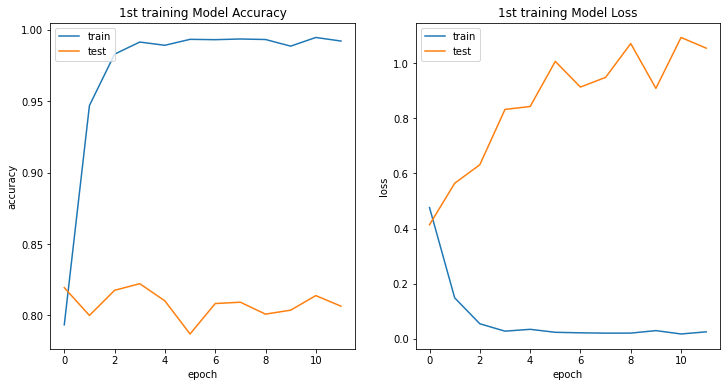

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('1st training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('1st training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
from keras.models import load_model

model = load_model(MODEL_INIT, compile=False)
opt = Adam(learning_rate=0.0001)
loss='categorical_crossentropy'
model.compile(opt, loss, metrics=['accuracy'])
model.evaluate(X_val, y_val)

79/79 [==============================] - 5s 62ms/step - loss: 0.9656 - accuracy: 0.7869


[0.9655516743659973, 0.7869047522544861]

In [21]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 2s 61ms/step - loss: 0.8323 - accuracy: 0.8222


[0.8322635889053345, 0.8222222328186035]

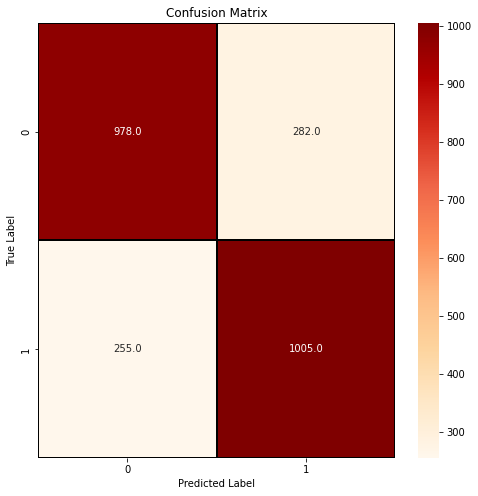

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1260
           1       0.78      0.80      0.79      1260

    accuracy                           0.79      2520
   macro avg       0.79      0.79      0.79      2520
weighted avg       0.79      0.79      0.79      2520



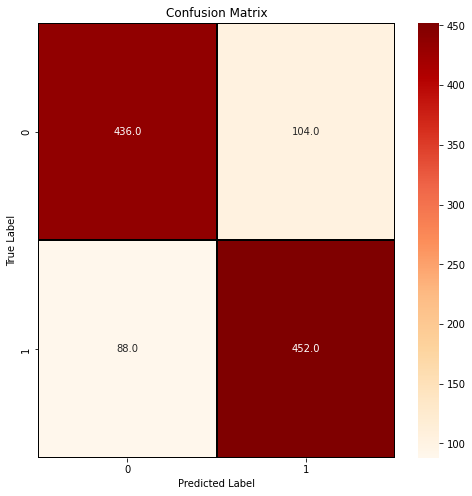

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       540
           1       0.81      0.84      0.82       540

    accuracy                           0.82      1080
   macro avg       0.82      0.82      0.82      1080
weighted avg       0.82      0.82      0.82      1080



In [30]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    #y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    #ps:all the Y value must turn back to 1 dimension array. otherwise, the scoring functions in sklearn cannot compare, and will give an error
    #classification metrics can't handle a mix of continuous-multioutput and multi-label-indicator targets
    
   # print("Train accuracy Score------------>")
   # print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

Val accuracy Score--------->
78.690 %
Test accuracy Score--------->
82.222 %
F1 Score--------------->
82.218 %
Cohen Kappa Score------------->
64.444 %
Recall-------------->
82.222 %
Precision-------------->
82.251 %


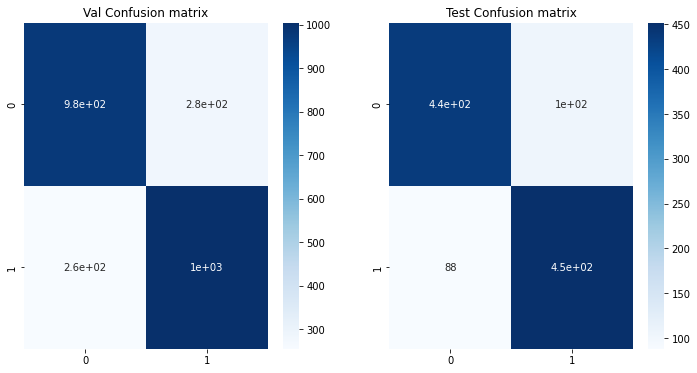

In [31]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)

# Second Training Fine Tune

In [32]:
for model1 in model.layers:
    model1.trainable = True

In [33]:
callbacks2 = [EarlyStopping(monitor='val_accuracy', patience=5, verbose=1), 
              ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)]
opt = Adam(learning_rate=0.001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [34]:
# model.load_weights("model.hdf5")
history2 = model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 30, callbacks=callbacks2)

Epoch 1/30
263/263 [==============================] - 22s 80ms/step - loss: 0.0592 - accuracy: 0.9789 - val_loss: 0.8243 - val_accuracy: 0.7963
Epoch 2/30
263/263 [==============================] - 21s 79ms/step - loss: 0.0405 - accuracy: 0.9860 - val_loss: 0.8799 - val_accuracy: 0.7926
Epoch 3/30
263/263 [==============================] - 21s 78ms/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.8995 - val_accuracy: 0.7981
Epoch 4/30
263/263 [==============================] - 21s 78ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 1.0029 - val_accuracy: 0.8009
Epoch 5/30
263/263 [==============================] - 21s 79ms/step - loss: 0.0246 - accuracy: 0.9911 - val_loss: 0.8668 - val_accuracy: 0.7954
Epoch 6/30
263/263 [==============================] - 21s 78ms/step - loss: 0.0322 - accuracy: 0.9895 - val_loss: 0.8571 - val_accuracy: 0.8019
Epoch 7/30
263/263 [==============================] - 21s 79ms/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 1.0332 - val_accuracy:

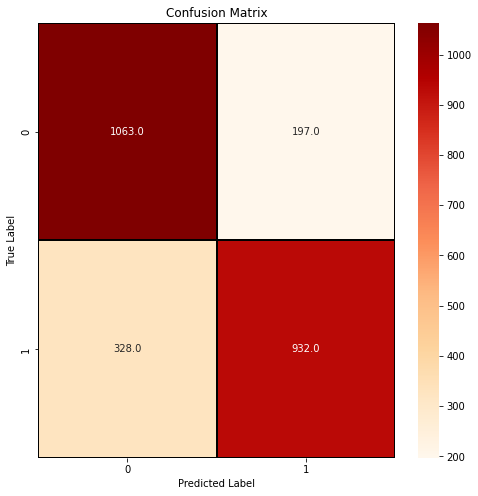

In [35]:
model = load_model(MODEL_PATH, compile=False)
opt = Adam(learning_rate=0.0001)
loss='categorical_crossentropy'
model.compile(opt, loss, metrics=['accuracy'])

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [36]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1260
           1       0.83      0.74      0.78      1260

    accuracy                           0.79      2520
   macro avg       0.79      0.79      0.79      2520
weighted avg       0.79      0.79      0.79      2520



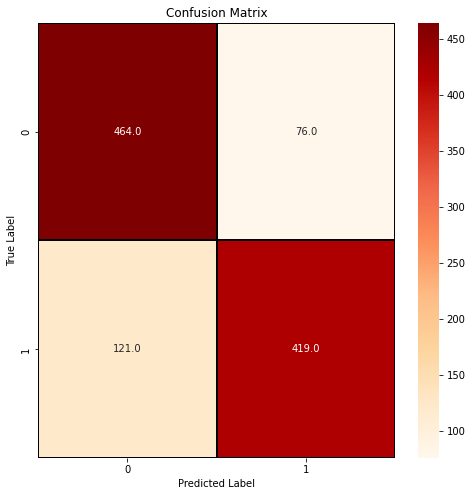

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       540
           1       0.85      0.78      0.81       540

    accuracy                           0.82      1080
   macro avg       0.82      0.82      0.82      1080
weighted avg       0.82      0.82      0.82      1080



In [37]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(Y_true, Y_pred_classes))

Val accuracy Score--------->
79.167 %
Test accuracy Score--------->
81.759 %
F1 Score--------------->
81.728 %
Cohen Kappa Score------------->
63.519 %
Recall-------------->
81.759 %
Precision-------------->
81.981 %


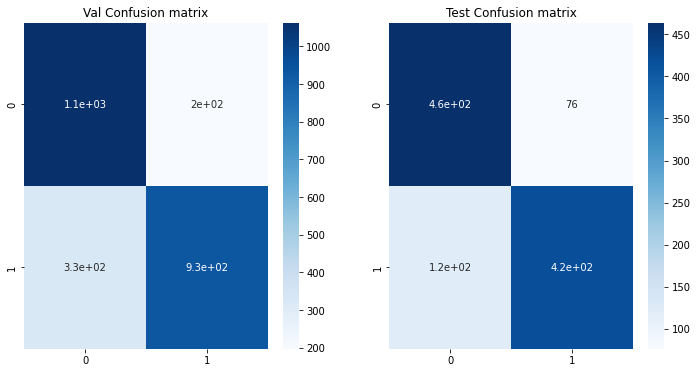

In [38]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)